# Juego de la Vida (Game of Life)

El **Juego de la Vida**, también conocido como **Vida**, es un autómata celular diseñador por el matemático británico John Horton Conway en 1970. Es un juego sin jugadores, esto significa que su evolución está determinada por su estado inicial, sin requerir más entradas. Uno interactúa con el Juego de la Vida al crear un estado inicial (o configuración inicial) y se observa como evoluciona. Es Turing completo (puede simular cualquier máquina de Turing) y puede simular un constructor universal o cualquier otra máquina de Turing.

<center>
<img src="https://1.bp.blogspot.com/-pdQ2ckeQzCw/WwGFbYTKRoI/AAAAAAAAAY8/kb-gcutnkKc2TnQainAlYK5FlWmv87XywCPcBGAYYCw/s1600/ezgif.com-video-to-gif.gif" width=250 height=250 />
</center>

## Reglas

El universo (o entorno) del Juego de la Vida es infinito, cuadrícula ortogonal bidimensional de celdas cuadradas, cada una de ellas se encuentra con uno de dos posibles estados, vivo o muerto (poblado o despoblado, respectivamente). Cada celda interactúa con ocho vecinos, que son las celdas adyacentes horizontales, verticales y diagonales. En cada paso de tiempo, las siguientes transiciones ocurren:

1. Cualquier celda viva con menos de dos vecinos vivos muere, debido a la subpoblación.
2. Cualquier celda viva con dos o tres vecinos vivos sobrevive para la siguiente generación.
3. Cualquier celda con más de tres vecinos vivos muere, debido a la sobrepoblación.
4. Cualquier celda muerta con exactamente tres vecinos vivos se convierte en una celda viva, debido a la reproducción.
5. Cualquier celda viva con al menos un vecino infectado se infecta, lo contagia.
6. cualquier celda infectada sola o con 3 celdas vivas se cura, aislamiento.
7. cualquier celda infectada con mas de 3 celdas infectadas se muere, nadie lo cuida.
7. cualquier celda infectada con mas de una celda infectada continua infectada.

Estas reglas, que comparan el comportamiento del autómata a la vida real, pueden ser condensadas en lo siguiente:

1. Cualquier celda viva con dos o más vecinos vivos sobrevive.
2. Cualquier celda muerta con tres vecinos vivos se convierte en una celda viva.
3. Cualquier otra celda viva muere en la siguiente generación. De manera similar, cualquier otra celda muerta se queda muerta.

El patrón inicial constituye la semilla del sistema. La primera generación es creada al aplicar las reglas anteriores de manera simultanea a cualquier celda en la semilla, viva o muerta; nacimientos y muertes ocurren simultáneamente, y el momento discreto en el cual esto pasa es a veces llamado turno. Cada generación es una función pura de la anterior. Las reglas se aplican de forma repetida para crear nuevas generaciones.

In [383]:
# !python3 -m pip install mesa

## Imports

Antes de empezar a crear el modelo del juego de la vida con multiagentes es necesario tener instalado los siguientes paquetes:
- `python`: asegúrense de usar la versión 3+.
- `mesa`: el framework de Python para el modelado de agentes.
- `numpy`: es una biblioteca de Python para el manejo de matrices, arreglos, manipulación matemática, lógica y mucho más.
- `matplotlib`: es una biblioteca para crear visualizaciones estáticas, animadas e interactivas en Python.

Para poder modelar el juego de la vida usando el framework de `mesa` es necesario importar dos clases: una para el modelo general, y otro para los agentes. 

In [384]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
from mesa import Agent, Model 

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [385]:
old_cmap = mlp.cm.get_cmap('viridis', 2)
colors = old_cmap(np.linspace(0, 1, 3))

colors[0] = np.array([10/256, 10/256, 10/256, 1]) # black muerto
colors[1] = np.array([0/256, 256/256, 0/256, 1]) # Green vivo
colors[2] = np.array([145/256, 94/256, 55/256, 1]) # Brown enfermo

# colors[2] = np.array([150/256, 150/256, 150/256, 1]) # Grey
# colors[4] = np.array([130/256, 130/256, 50/256, 1]) # Olive
# colors[5] = np.array([10/256, 100/256, 20/256, 1]) # Dark Green
#
# colors[6] = np.array([250/256, 250/256, 250/256, 1]) # White
# colors[7] = np.array([86/256, 102/256, 255/256, 1]) # Blue
# colors[8] = np.array([185/256, 89/256, 255/256, 1]) # Purple
# colors[9] = np.array([10/256, 10/256, 10/256, 1]) # Black
colormap = mlp.colors.ListedColormap(colors)

## Crear el modelo

Antes que nada el presente modelo se encuentra basado en el [tutorial introductorio](https://mesa.readthedocs.io/en/latest/tutorials/intro_tutorial.html). Se modificó para que funcionara con el presente problema pero en esencia es lo mismo.

In [386]:
class GameLifeAgent(Agent):
    """
    Representa a un agente o una celda con estado vivo (1) o muerto (0)
    """
    def __init__(self, unique_id, model):
        """
        Crea un agente con estado inicial aleatorio de 0 ó 1, también se le asigna un identificador
        formado por una tupla (x,y). Se define un nuevo estado cuyo valor será definido por las
        reglas mencionadas arriba.
        """
        super().__init__(unique_id, model)
        self.live = np.random.choice([0,1,2])
        self.next_state = None
    
    def step(self):
        """
        Este método es el que calcula si la celda vivirá o morirá dependiendo el estado de sus vecinos.
        Esta es la dinámica principal del juego de la vida. Por lo tanto, el estado live de la
        siguiente generación no se cambia aquí, solo se almacena en self.next_state. La idea consiste
        en esperar a que todos los agentes calculen su estado y una vez hecho esto, hacer el cambio.
        """

        neighbours = self.model.grid.get_neighbors(
            self.pos,
            moore=True,
            include_center=False)

        # live_neighbours = np.sum([neighbour.live for neighbour in neighbours])
        
        live_neighbours = 0
        for neighbor in neighbours:
            live_neighbours = live_neighbours + neighbor.live

        infected_neighbours = 0
        for neighbor in neighbours:
            infected_neighbours = infected_neighbours + neighbor.live

        self.next_state = self.live
        if self.next_state == 2 and (infected_neighbours > 2):
            self.next_state = 0
        else:
            if self.next_state ==2 and (infected_neighbours < 1) and (live_neighbours < 1):
                self.next_state = 1
            else:
                if self.next_state == 1 and (infected_neighbours > 1):
                    self.next_state = 2
                else:
                    if self.next_state == 1 and (live_neighbours < 2 or live_neighbours > 3):
                        self.next_state = 0
                    else:
                        if live_neighbours == 3:
                            self.next_state = 1
    
    def advance(self):
        """
        Define el nuevo estado calculado del método step.
        """
        self.live = self.next_state
            
class GameLifeModel(Model):
    """
    Define el modelo del juego de la vida.
    """
    def __init__(self, width, height):
        self.width = width
        self.height = height

        self.reset()

    def reset(self):
        self.num_agents = self.width * self.height
        self.grid = SingleGrid(self.width, self.height, True)
        self.schedule = SimultaneousActivation(self)

        for (content, x, y) in self.grid.coord_iter():
            a = GameLifeAgent((x, y), self)
            self.grid.place_agent(a, (x, y))
            self.schedule.add(a)

        # Aquí definimos el colector de datos para obtener el grid completo.
        self.datacollector = DataCollector(
            model_reporters={"Grid": self.get_grid,
                             "Live": self.get_live,
                            "Infected": self.get_infected}
        )
    
    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        self.datacollector.collect(self)
        self.schedule.step()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            grid[x][y] = cell_content.live

        return grid

    def get_live(self):
        total_live_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, x, y = cell
            if isinstance(agent, GameLifeAgent) and (agent.live==1):
                total_live_agents += agent.live

        return total_live_agents
    
    def get_infected(self):
        total_infected_agents = 0

        # Por todas las celdas del grid
        for cell in model.grid.coord_iter():
            agent, x, y = cell
            if isinstance(agent, GameLifeAgent) and (agent.live==2):
                total_infected_agents += agent.live

        return total_infected_agents

# Ejecución del modelo
A continuación corremos el modelo

In [387]:
# Definimos el tamaño del Grid ..> 7 x 7
GRID_SIZE = 100

# Definimos el número de generaciones a correr
NUM_GENERATIONS = 50

# Registramos el tiempo de inicio y corremos el modelo
start_time = time.time()

model = GameLifeModel(GRID_SIZE, GRID_SIZE)
for i in range(NUM_GENERATIONS):
    model.step()
final_time = time.time()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(final_time - start_time))))

Tiempo de ejecución: 0:00:03.332289


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [388]:
all_grids = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [389]:
all_grids

,Grid,Live,Infected
0,"[[0.0, 2.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0,...",3443,6532
1,"[[0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",74,6924
2,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",157,1138
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",716,348
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",352,910
5,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0,...",443,792
6,"[[0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 2.0, 1.0, 0.0,...",415,1096
7,"[[0.0, 1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0,...",475,1084
8,"[[0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",540,1166
9,"[[1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",651,1332


In [390]:
%%capture

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

axs.set_xticks([])
axs.set_yticks([])

patch_grid = axs.imshow(model.get_grid(), cmap=colormap)

cells_alive = []
cells_infected = []
def animate(i):
    patch_grid.set_data(all_grids['Grid'].iloc[i])

    cells_alive.append(all_grids['Live'].iloc[i])

    cells_infected.append(all_grids['Infected'].iloc[i])

anim = animation.FuncAnimation(fig, animate, frames=NUM_GENERATIONS)

In [391]:
anim

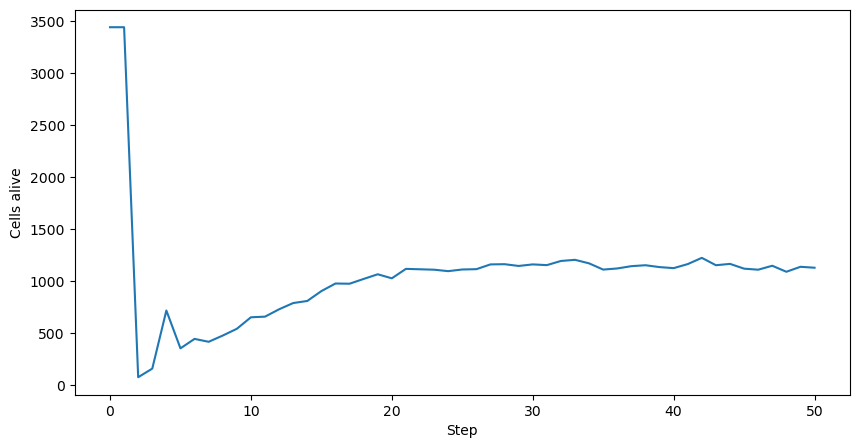

In [392]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Cells alive")

plt.plot(cells_alive)
plt.show()

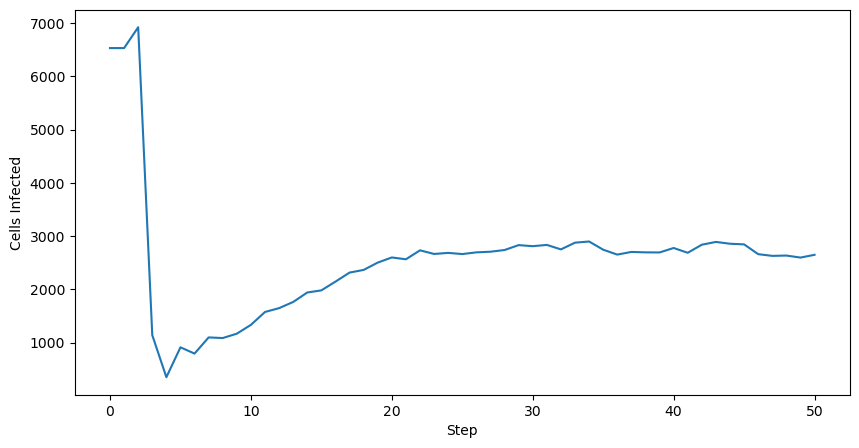

In [393]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Cells Infected")

plt.plot(cells_infected)
plt.show()

In [394]:
import random
random.sample([1, 2, 3, 5], k=2)

[5, 2]

# Batch simulation

In [395]:
NUM_REPS = 100
GRID_SIZE = 10
NUM_GENERATIONS = 1000

model = GameLifeModel(GRID_SIZE, GRID_SIZE)

batch_data = dict(time=[], alive=[], infected=[])
for _ in range(NUM_REPS):
    start_time = time.time()

    model.reset()
    for i in range(NUM_GENERATIONS):
        model.step()
    final_time = time.time()

    all_grids = model.datacollector.get_model_vars_dataframe()

    batch_data['time'].append(final_time - start_time)
    batch_data['alive'].append(all_grids['Live'].to_numpy())
    batch_data['infected'].append(all_grids['Infected'].to_numpy())


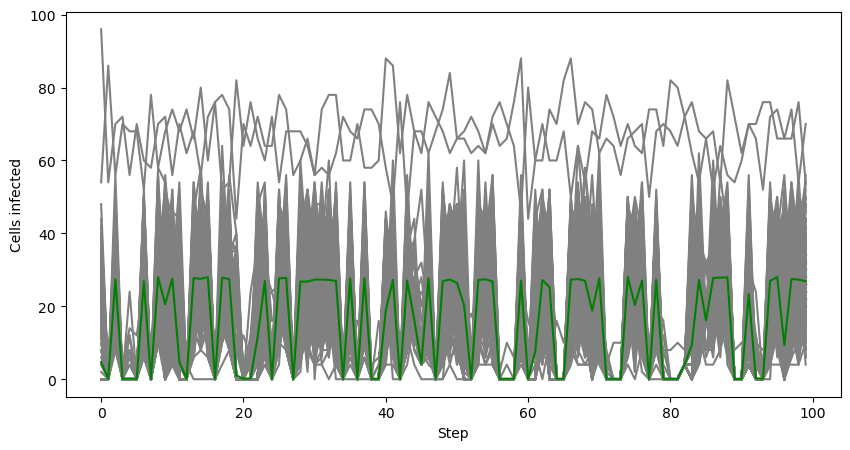

In [396]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Cells infected")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
plt.plot(batch_data['infected'], color='Gray')

plt.plot(np.average(np.array(batch_data['infected']), axis=1), color='Green')

plt.show()

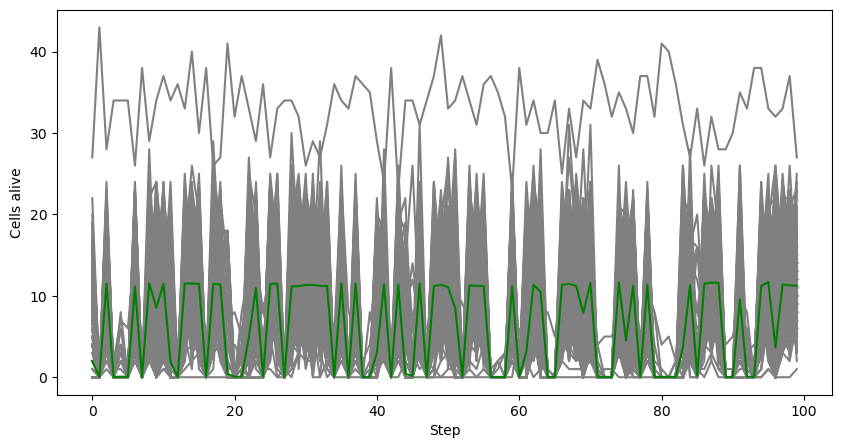

In [397]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

axs.set_xlabel("Step")
axs.set_ylabel("Cells alive")

#axs.set_prop_cycle('color', list(plt.cm.(np.linspace(0, 1, NUM_REPS))))
plt.plot(batch_data['alive'], color='Gray')

plt.plot(np.average(np.array(batch_data['alive']), axis=1), color='Green')

plt.show()